# Best Models

Define models:

In [1]:
source("helpers.r")
library(magrittr)


learner_A <- function(training, test) {
  name <- "lg full"
  
  fit <- glm(target ~ ., data=training, family =binomial(link = "logit"))
  y_probabilities <- predict(fit, test,  type="response")
  y_true <- ifelse(test$target == "no_disease", 0, 1)
  
  auc <- AUC(y_true = y_true, y_pred = y_probabilities)
  return(list(name = name, auc = auc))
}


learner_B <- function(training, test) {
  name <- "lg forwad selection"
  
  fit <- glm(target ~ thal + ca + cp + slope + oldpeak + sex + trestbps, data=training, family =binomial(link = "logit"))
  y_probabilities <- predict(fit, test,  type="response")
  y_true <- ifelse(test$target == "no_disease", 0, 1)
  
  auc <- AUC(y_true = y_true, y_pred = y_probabilities)
  return(list(name = name, auc = auc))
}

learner_C <- function(training, test) {   
  name <- "glm 5 variables LASSO"
    
  fit <- glm(target ~ thalach + oldpeak + ca + cp + thal, data=training, family = binomial(link = "logit"))
  y_probabilities <- predict(fit, test,  type="response")
  y_true <- ifelse(test$target == "no_disease", 0, 1)
    
  auc <- AUC(y_true = y_true, y_pred = y_probabilities)
  return(list(name = name, auc = auc))

}


Warning message:
"package 'tidyverse' was built under R version 3.6.1"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning message:
"package 'caret' was built under R version 3.6.1"Loading required package: lattice

Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift

Warning message:
"package 'MLmetrics' was built under R version 3.6.1"
Attaching package: 'MLmetrics'

The following objects are masked from 'package:caret':

    MAE, RMSE

The following object is 

Compare the models:

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_double(),
  thal = col_double(),
  target = col_double()
)


model,MeanAUC
lg forwad selection,0.9227572
glm 5 variables LASSO,0.9054346
lg full,0.9035265


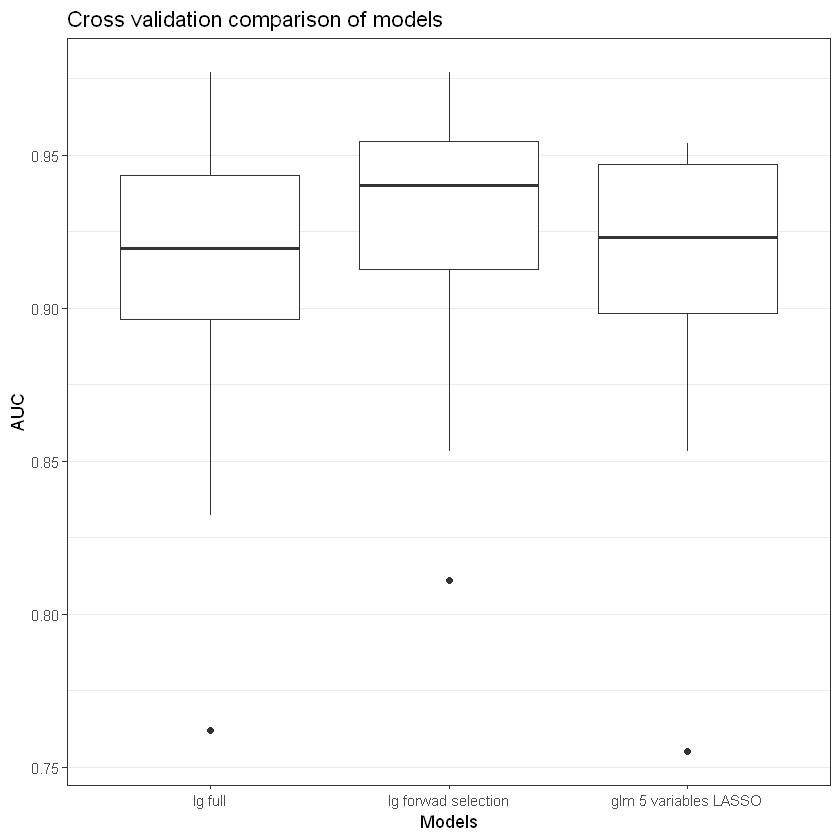

In [2]:
df <- get_training_df_clean()

learners <- list(learner_A, learner_B, learner_C)

result <- cv_compare_learner(learners, df)

plot_best_learners(result)

result %>% 
  group_by(model) %>%
  summarise(MeanAUC = mean(auc)) %>%
  arrange(desc(MeanAUC))